# Exercise 9: U-Net - Solutions

U-Net is a convolutional neural network that was developed initially for biomedical image segmentation. This week, we will be working on implementing the U-Net architecture using PyTorch and performing an image segmentation task.

This network is a bit more complicated than the MLP and simple CNN you have seen so far, but it is a nice example of what PyTorch allows to do!

In [13]:
import numpy as np
import copy
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import helper
import simulation

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Today we will be working with a small dataset of synthetic images. Let us generate 2 images with their segmentation masks.

In [14]:
# Generate some random images
input_images, target_masks = simulation.generate_random_data(80, 80, count=2)

print(f"Input images have shape {input_images.shape}. Min value in image: {input_images.min()}. Max value in image: {input_images.max()}.")
print(f"Image masks have shape {target_masks.shape}. Min value in mask: {target_masks.min()}. Max value in mask: {target_masks.max()}.")

Input images have shape (2, 1, 80, 80). Min value in image: 0. Max value in image: 255.
Image masks have shape (2, 5, 80, 80). Min value in mask: 0.0. Max value in mask: 1.0.


The input images have shape $(2, 1, 80, 80)$:  $2$ for the number of images, $1$ for the color channels (they are black and white in this case), and $(80,80)$ for the image height and width.

The images contain 5 different shapes. For each input image we have a segmentation mask, with which we encode what shape the pixels in the image segment.

The corresponding image masks have shape $(2, 5, 80, 80)$: $2$ for the number of images, $5$ for the one-hot encoding of what shape the pixel is a part of (see image below), and $(80,80)$ for the image height and width.

Let us plot the image and the corresponding segmentation mask to get a better idea of our data.

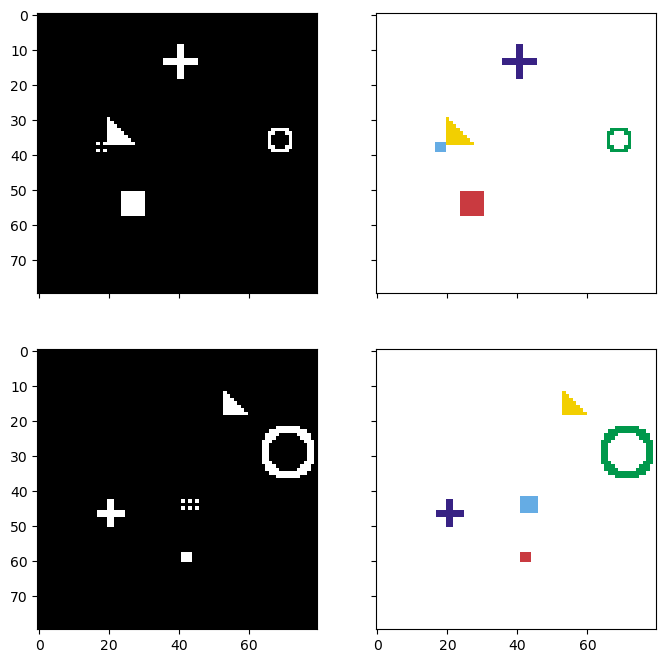

In [15]:
# Change channel-order and make 3 channels just for plotting
input_images_rgb = [x.astype(np.uint8).repeat(3,axis=0).transpose(1,2,0) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# Left: Input image (black and white), Right: Target mask (5ch)
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

Now we will be using PyTorch's Dataset class for preparing the data. Our `SimDataset` class will inherit from PyTorch's dataset class. We need to overwrite the functions `__len__(self)`, and `__getitem__(self, idx)`.

*  `__len__(self)`: returns the size of the dataset.

* `__getitem__(self, idx)`: returns the data (and its target) sample of index `idx`.


(Hint: The tutorial at https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class is very helpful and we encourage you to have a look at it. You can also add transformations for data augmentation etc. very easily!)

In [16]:
class SimDataset(Dataset):
    def __init__(self, count):
        # We generate our data 
        self.input_images, self.target_masks = simulation.generate_random_data(80, 80, count=count)

    def __len__(self):
        ### WRITE YOUR CODE HERE. Return the size of the dataset
        return len(self.input_images)

    def __getitem__(self, idx):
        ### WRITE YOUR CODE HERE. Select data and mask at index idx.
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        
        return [image, mask]

Now, we will use PyTorch's `DataLoader` class. This is an iterator which allows us to batch the data, shuffle it and load it with multiprocessing workers in parallel.

In [17]:
# Create the datasets and use PyTorch's DataLoader class.
train_set = SimDataset(300)
val_set = SimDataset(20)
test_set = SimDataset(3)

train_dataloader = DataLoader(train_set, batch_size=20, shuffle=True)
val_dataloader= DataLoader(val_set, batch_size=20, shuffle=True)
test_dataloader= DataLoader(test_set, batch_size=3, shuffle=False)

Now that we have our Dataset and Dataloader, it is time to design our deep network! Since we are doing image segmentation, we choose to use a U-Net architecture here, which was first introduced in the paper "U-Net: Convolutional Networks for Biomedical Image Segmentation" ([link to paper](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) for the interested). The original architecture looks like this:

<img src="img/unet.png" width=800></img>

We will quote the architecture description from the paper directly: 

> It consists of a contracting path (left side) and an expansive path (right side). 

> The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of **two 3x3 convolutions** (unpadded convolutions), each followed by a **rectified linear unit (ReLU)** and a **2x2 max pooling operation with stride 2** for downsampling. At each downsampling step we double the number of feature channels. 


> Every step in the expansive path consists of an **upsampling** of the feature map followed by a **2x2 convolution (“up-convolution”)** that halves the number of feature channels, a **concatenation with the correspondingly cropped feature map** from the contracting path, and **two 3x3 convolutions**, each followed by a **ReLU**. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a 1x1 convolution is used to map each 64- component feature vector to the desired number of classes. In total the network has 23 convolutional layers.

In our case, we make matters slightly simpler by using **padded convolutions with padding of size 1**, so that the image doesn't become smaller after the convolution operations. This way, **we do not have to crop** the feature map from the contracting path for the concatenation. We will also build a slightly smaller network, since our images are not so large in size to begin with. The network we want to implement is shown below.

<img src="img/unet-2.png" width=800></img>

So now lets code this! We would like to first create a module class for the double convolution operation (convolution -> batch norm -> ReLU -> convolution -> batch norm -> ReLU), since it is repeated several times in the architecture. This class inherits from PyTorch's module class. We use the [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to define the layers in this module. 

Just to show you how this works, we wrote the class for a single convolution followed by a Sigmoid operation called `DummyConv`. We then use this `DummyConv` module three times in the `DummyNetwork`. Study how this works. 

**Note:** [batch normalization](https://en.wikipedia.org/wiki/Batch_normalization) is a technique for normalizing each batch of data within the network, to help its training. If you haven't seen it in the lectures, you don't need to know its details.

In [18]:
class DummyConv(nn.Module):
    """A small module that implements (convolution => sigmoid).
    It will be re-used as a build block to make a full network."""

    def __init__(self, in_channels, out_channels):            
        super().__init__()
        
        # We build a sequence of layers with nn.Sequential().
        self.single_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid(inplace=True)
        )

    def forward(self, x):
        return self.single_conv(x)


class DummyNetwork(nn.Module):
    """A network that uses the DummyConv modules above."""

    def __init__(self, n_channels):
        super().__init__()
        
        self.initial_layer = DummyConv(n_channels, 64)
        self.second_layer = DummyConv(64, 128)
        self.third_layer = DummyConv(128, 256)

    def forward(self, x):
        x1 = self.initial_layer(x)
        x2 = self.second_layer(x1)
        x3 = self.third_layer(x2)
        return x3

Now you are ready to implement the `DoubleConv` module. Use the template above as help!

In [19]:
class DoubleConv(nn.Module):
    """A module that will implement the following sequence of layers:
    (convolution => batch normalization => ReLU => convolution => batch normalization => ReLU).
    Batch normalization is a technique for normalization over mini-batches. 
    To use it in a CNN, you can use PyTorch's nn.BatchNorm2d layer:
    https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html.
    """
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        ### WRITE YOUR CODE HERE
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        ### WRITE YOUR CODE HERE
        return self.double_conv(x)

Now let us implement the `UNet` class, as we did in previous week's exercise. We've started the implementation as a hint and left the rest for you to fill.

For the **up-and-conv 2x2** operation of the network, as shown on the illustrations, we will be using **Transposed Convolutions**. You can take a look at [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d) for the PyTorch implementation. *Hint:* You should take an interest in the arguments `kernel_size` and `stride`.

In [20]:
class UNet(nn.Module):
    def __init__(self, input_channels, n_classes):
        super().__init__()

        # Beginning of the "contracting" part of the U-Net
        self.dc1 = DoubleConv(input_channels, 64)
        self.mp1 = nn.MaxPool2d(2)
        self.dc2 = DoubleConv(64, 128)
        
        ### WRITE YOUR CODE HERE: prepare the layers we need for the forward pass.
        self.mp2 = nn.MaxPool2d(2)
        self.dc3 = DoubleConv(128, 256)
        self.mp3 = nn.MaxPool2d(2)
        self.dc4 = DoubleConv(256, 512)

        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dc5 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dc6 = DoubleConv(256, 128)
        ###
        
        # End of the "expansive" part of the U-Net
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dc7 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        
        x1 = self.dc1(x)
        x2 = self.mp1(x1)
        x2 = self.dc2(x2)
        
        ### WRITE YOUR CODE HERE
        x3 = self.mp2(x2)
        x3 = self.dc3(x3)
        x4 = self.mp3(x3)
        x4 = self.dc4(x4)

        x = self.up1(x4)
        x = torch.cat([x3, x], dim=1)
        x = self.dc5(x)
        x = self.up2(x)
        x = torch.cat([x2, x], dim=1)
        x = self.dc6(x)
        ### 
                 
        x = self.up3(x)
        x = torch.cat([x1, x], dim=1)
        x = self.dc7(x)
        logits = self.outc(x)
        return logits

Now let's create this architecture.

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(input_channels=1, n_classes=5)
model = model.to(device)

We use a sum of binary cross entropy losses and dice loss for our loss, since image segmentation is actually a classification problem (you can think of it as classifying what object the pixels belong to, if they belong to any.) You're already familiar with cross entropy loss from the lectures. Dice loss is a measure of overlap between the prediction and the ground truth labels and is also used for image segmentation tasks.


In [22]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def full_loss(pred, target):
    bce_weight = 0.5
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    loss = bce * bce_weight + dice * (1 - bce_weight)
    return loss


The training code is given below. Fill in the missing part of the training loop! Call the `full_loss` function above to calculate the loss.

In [23]:
def train_model(model, optimizer, scheduler, num_epochs=10):
    best_loss = 1e10
    best_model_wts = None
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()
        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])

        ##### TRAINING:
        model.train()  # Set model to training mode
        epoch_loss = 0
        epoch_samples = 0
        #load the images and masks
        for bi, (inputs, labels) in enumerate(train_dataloader):
            print(f"\rProcessing batch {bi}/"
                  f"{len(train_dataloader) - 1}", end='')
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()

            ### WRITE YOUR CODE HERE: one step of the training loop.
            outputs = model(inputs)
            loss = full_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # statistics
            epoch_samples +=  inputs.size(0)
            epoch_loss += loss.data.cpu().numpy() * inputs.size(0)
        print("Training epoch loss: {}".format(epoch_loss/epoch_samples))
        scheduler.step()

        ##### VALIDATION:
        model.eval()   # Set model to evaluate mode
        epoch_loss = 0
        epoch_samples = 0
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()

            with torch.no_grad():  # disable gradient calculation
                outputs = model(inputs)
                loss = full_loss(outputs, labels)

                # statistics
                epoch_loss += loss.data.cpu().numpy() * inputs.size(0)
                epoch_samples +=  inputs.size(0)
        print("Val epoch loss: {}".format(epoch_loss/epoch_samples))

        # save the model if the loss is the best
        if epoch_loss/epoch_samples < best_loss:
            print("saving best model")
            best_loss = epoch_loss/epoch_samples
            best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)


And finally, it is time to train! 

First we will create the optimizer. This time we will use the Adam optimizer ([optim.Adam](https://pytorch.org/docs/stable/optim.html)). Set the learning rate to 1e-2.

We've also created a learning rate scheduler for you, which gradually reduces the learning rate during training, this can be useful to converge to a better solution. The intuition behind it is that the closer we get to a minima, the smaller the step we want to get closer and closer.

If you have a GPU with CUDA support, this should be pretty fast! However, **it might take a while if you only train on the CPU**. If this is the case, try it with a reduced number of epochs first. You should be seeing some segmented objects after 3 epochs (but keep in mind that at this point the classification will be likely wrong, i.e. visually the colors will not match).

In [24]:
model = UNet(input_channels=1, n_classes=5)
model = model.to(device)
optimizer_ft = optim.Adam(model.parameters(), lr=1e-2)  ### WRITE YOUR CODE HERE
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.9)
train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
LR 0.01
Processing batch 14/14Training epoch loss: 0.5985258281230926
Val epoch loss: 1.8174092769622803
saving best model
0m 28s
Epoch 1/9
----------
LR 0.01
Processing batch 14/14Training epoch loss: 0.39764697949091593
Val epoch loss: 0.39069634675979614
saving best model
0m 29s
Epoch 2/9
----------
LR 0.01
Processing batch 14/14Training epoch loss: 0.34134846528371177
Val epoch loss: 0.36061689257621765
saving best model
0m 29s
Epoch 3/9
----------
LR 0.009000000000000001
Processing batch 14/14Training epoch loss: 0.27890560726324715
Val epoch loss: 0.26231706142425537
saving best model
0m 29s
Epoch 4/9
----------
LR 0.009000000000000001
Processing batch 14/14Training epoch loss: 0.19122075488169987
Val epoch loss: 0.22425220906734467
saving best model
0m 28s
Epoch 5/9
----------
LR 0.009000000000000001
Processing batch 14/14Training epoch loss: 0.09721318334341049
Val epoch loss: 0.09082316607236862
saving best model
0m 29s
Epoch 6/9
----------
LR 0.0081000000

Now let's see how well we do on the test data! We plot the ground truth masks and the predicted masks side by side below.

We plot the input, target, and prediction for the test set:


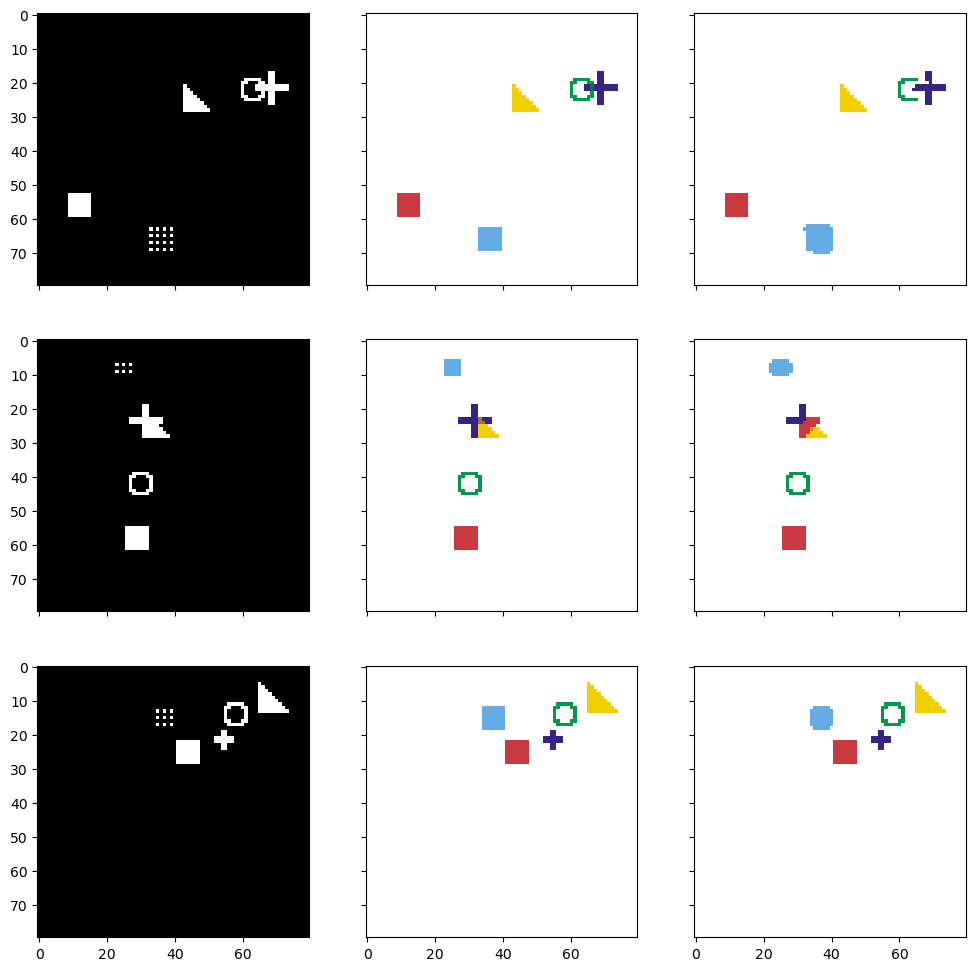

In [25]:
# Get the first batch
inputs, labels = next(iter(test_dataloader))
inputs = inputs.to(device).float()
labels = labels.to(device).float()

# Predict
pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.repeat(3,axis=0).transpose(1,2,0).astype(np.uint8) for x in inputs.cpu().numpy()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]
print("We plot the input, target, and prediction for the test set:")
helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

**Acknowledgements:**

This notebook contains a mix of usuyama's https://github.com/usuyama/pytorch-unet and milesial's https://github.com/milesial/Pytorch-UNet code.

# Written questions

**Q.1** We use a convolution with a kernel of size $K\times K$ on an image of size $S\times S$. 
1. What will be the size of the output if we don't use padding?
2. So how much padding should we use to maintain the size $S\times S$? *Hint:* how to pad each side of the image? Is there a difference when the kernel size is odd vs. even?

**A.1**
1. The output feature map will be of size $(S - K + 1)\times(S - K + 1)$.
2. So we need to pad the image by $K - 1$ for both its height and width, and we should pad each side of the image by $\frac{K-1}{2}$. If $K$ is odd, then there is no problem. But if $K$ is even, we will need to pad one side with one more pixel (e.g., $\frac{K-2}{2}$ for the left side and $\frac{K}{2}$ for the right side). This is why we usually use odd-sized kernel; it is simpler and symmetric!

**Q.2** CIFAR-10 is an image database that contains color images of size $32\times32$, which can therefore be represented by $3\times32\times32$ arrays (taking the convention of putting the channels first). The goal is to classify them into 10 different classes.
        
To this end, we use a small Convolutional Neural Network (CNN) made of convolutional layers ($\texttt{Conv2d}$), max-pooling layers ($\texttt{MaxPool2d}$), and fully-connected layers ($\texttt{FC}$), and $\texttt{ReLU}$ activation functions. Let us parameterize these layers as follows: 
* $\texttt{Conv2d(\#kernels, kernel-size)}$,
* $\texttt{MaxPool2d(kernel-size)}$,
* $\texttt{FC(\#neurons)}$. 

For example, a layer denoted as $\texttt{Conv2d(8, 4)}$ consists of $8$ kernels (or filters) of size $4\times4$. **All convolutions uses a stride of $1$ without padding.** Additionally, the feature maps can be flattened into a vector before being fed to the fully-connected layer. 

Given these conventions, we use the following network architecture:
    
$$\texttt{Conv2d(16, 5)} \rightarrow \texttt{MaxPool2d(2)} \rightarrow \texttt{Conv2d(32, 3)} \rightarrow \texttt{Conv2d(32, 3)} \rightarrow \texttt{MaxPool2d(2)} \rightarrow \texttt{FC(10)}$$
    
What sizes are:
1. the feature maps after the second convolution and before the third,
2. the input to the fully-connected layer ($\texttt{FC}$)? 

**A.2**   
1. After the second convolution and before the third, the feature maps are of size $32\times12\times12$.
2. The input to the fully-connected layer ($\texttt{FC}$) is of size $32*5*5=800$, as we flatten it first.

**Q.3** Considering the same convention as above, but with a dataset that contains color images of size $224\times224$, build a network to classify them into 100 classes.

As constraints for building your network, you need to
1. use the three layers presented above,
2. have the input to the final fully-connected layers be of size $128*7*7=6'272$,
3. and, when using $\texttt{MaxPool2d}$, you need to make sure that the feature maps are divisible by its kernel-size!

**A.3** Here is an example of such network:

$$\texttt{Conv2d(32, 3)} \rightarrow \texttt{Conv2d(32, 3)} \rightarrow \texttt{MaxPool2d(2)} \rightarrow \texttt{Conv2d(64, 11)} \rightarrow \texttt{MaxPool2d(4)} \rightarrow\\ \texttt{Conv2d(128, 5)} \rightarrow \texttt{MaxPool2d(3)} \rightarrow \texttt{FC(1024)} \rightarrow \texttt{FC(100)}$$

The shape of the feature maps evolves like so through this network: (taking the convention of channels first)

$$3\times224\times224 \rightarrow 32\times222\times222 \rightarrow 32\times220\times220 \rightarrow 32\times110\times110 \rightarrow 64\times100\times100 \rightarrow 64\times25\times25 \rightarrow\\ 128\times21\times21\rightarrow 128\times7\times7=6'272 \rightarrow 1024 \rightarrow 100$$

**Q.4** (MCQ) Select all the correct statement(s) below regarding CNNs:

1. MLPs are more robust to translations of the input than CNNs. (Imagine the image of an object, and if we translate that object over the image.)
2. Convolutional layers cannot be used to reduce the size of feature maps by a factor of, for example, $2$.
3. Increasing the size of the feature maps (i.e., up-sampling them) can be implemented using transposed convolutions.
4. Amongst other things, CNNs can be used for image classification but also to output images.

**A.4** Correct answers are 3 and 4.